# Credit Card Fraud Detection using Machine Learning

## 1. Introduction

Credit card fraud is a common challenge for financial institutions and can lead to financial losses and reduced customer trust. Detecting fraudulent transactions quickly and accurately is essential to reduce risk and ensure a safe payment experience for customers.

This project explores fraud detection from a practical perspective, focusing on how data-driven models can support transaction validation processes in real-world scenarios.

The main goals of this project are to:

* Analyze transaction patterns in credit card data
* Address extreme class imbalance
* Build and evaluate Machine Learning models for fraud detection


## 2. Business Problem

Financial institutions process a large number of transactions every day, which makes manual fraud detection unrealistic. Automated systems are needed to flag potentially fraudulent transactions quickly.

From a business perspective, the main challenge of fraud detection is to balance two outcomes:

* Missing a fraudulent transaction may lead to financial losses
* Incorrectly blocking a legitimate transaction can negatively impact the customer experience

An effective fraud detection model should help balance these two outcomes by identifying fraudulent transactions while keeping false positives at an acceptable level.

## 3. Data Overview
The dataset used in this project originates from Kaggle:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

It contains credit card transactions made by European cardholders in September 2013. The transactions occurred over a two-day period and include a total of 284,807 records, of which 492 are labeled as fraudulent.

For privacy reasons, all input features are numerical and were transformed using Principal Component Analysis (PCA). The dataset includes:

* `V1` to `V28`: Principal components obtained through PCA
* `Time`: Seconds elapsed between each transaction and the first transaction in the dataset
* `Amount`: Transaction amount
* `Class`: Target variable, where 1 represents fraud and 0 represents a legitimate transaction

The dataset is highly imbalanced, with fraudulent transactions representing a very small portion of the data. Because of this, accuracy alone is not a reliable metric, and the models are evaluated using metrics that better reflect fraud detection performance.

In [54]:
# Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [56]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 4. Data Exploration & Insights

In this section, we explore the data to better understand its main characteristics and identify patterns that are relevant for fraud detection.


### 4.1 Class Distribution

We start by examining the distribution of the target variable `Class` to understand how frequent fraudulent transactions are in the dataset.

In [57]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [58]:
print(df['Class'].value_counts(normalize=True))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


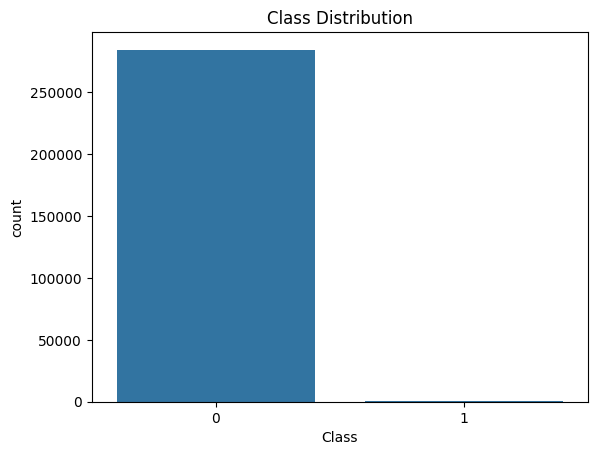

In [59]:
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

The dataset is extremely imbalanced.
* Legitimate transactions (Class = 0) represent the vast majority of the data
* Fraudulent transactions (Class = 1) account for only a very small fraction.

This imbalance highlights one of the main challenges of fraud detection. A model could achieve high accuracy by predicting all transactions as legitimate, while still failing to identify fraudulent cases. For this reason, accuracy alone is not a reliable evaluation metric for this problem.

### 4.2 Transaction Amount Distribution

We analyze the distribution of transaction amounts to better understand general spending behavior.


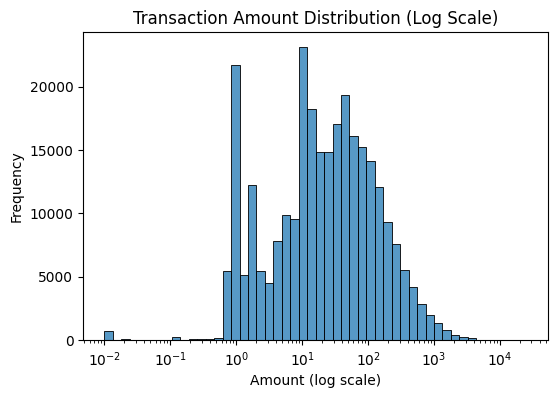

In [60]:
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, log_scale=True)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Amount (log scale)')
plt.ylabel('Frequency')
plt.show()

The transaction amount distribution is highly right-skewed:
* most transactions involve small amounts,
* a small number of transactions reach very high values

This pattern is common in financial transaction data and explains why the distribution appears concentrated near zero, with a long tail extending toward higher values.

### 4.3 Transaction Amount by Class

We now compare transaction amounts between legitimate and fraudulent transactions.


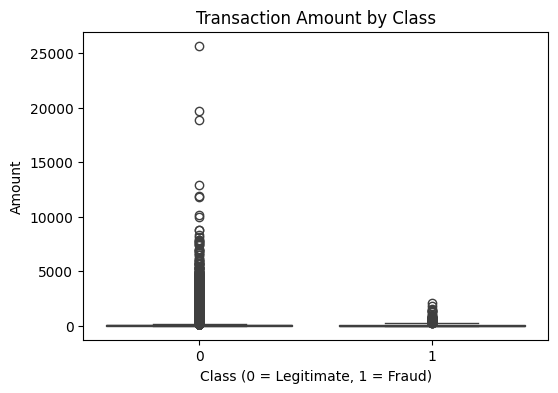

In [61]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Amount')
plt.show()

Fraudulent transactions tend to occur at lower amounts compared to legitimate ones, although some outliers are present.

Due to the strong class imbalance, fraudulent transactions appear compressed near the lower range of amounts when plotted alongside legitimate transactions. This visualization highlights the difficulty of analyzing minority classes in highly imbalanced datasets.


 ### 4.4 EDA Insights

The exploratory analysis highlights a few important points:

* The dataset is highly imbalanced, with fraudulent transactions representing a very small portion of the data
* Transaction amounts are heavily skewed, with most transactions involving low values
* Fraudulent transactions tend to occur at lower amounts, although exceptions exist

These insights reinforce the need for careful data preparation, appropriate evaluation metrics, and models that are suitable for rare event detection.


## 5. Data Preprocessing

Before training the Machine Learning models, the data needs to be prepared to ensure reliable and fair evaluation. This step focuses on separating features and targets, splitting the data, scaling numerical values, and addressing class imbalance.

### 5.1 Feature and Target Separation

The dataset was split into features (`X`) and target (`y`), where the target variable `Class` indicates whether a transaction is fraudulent.

In [62]:
X = df.drop("Class", axis=1)
y = df["Class"]

### 5.2 Train-Test Split

To evaluate model performance on unseen data, the dataset is split into training and test sets. A stratified split is used to preserve the original class distribution in both sets, which is especially important for highly imbalanced data.


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

This ensures that both the training and test sets contain a representative proportion of fraudulent and legitimate transactions.


### 5.3 Feature Scaling

Most features in the dataset have already been transformed using PCA and are on a similar scale. However, the `Amount` feature is not scaled and may disproportionately influence model training if left untreated.

For this reason, standardization is applied to the `Amount` feature.


In [64]:
scaler = StandardScaler()

X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
X_test["Amount"] = scaler.transform(X_test[["Amount"]])

Scaling helps ensure that all features contribute more equally during model training.

### 5.4 Handling Class Imbalance

The dataset is extremely imbalanced, with fraudulent transactions representing less than 0.2% of all records. When trained without any adjustment, models tend to favor the majority class and fail to detect fraudulent transactions.

To mitigate this issue, class weighting is applied during model training. This approach penalizes misclassification of the minority class more heavily, encouraging the model to focus on detecting fraudulent transactions.

Class imbalance handling is incorporated directly into the model configuration, rather than modifying the original data distribution.

## 6. Modeling

In this section, we train and evaluate Machine Learning models to detect fraudulent credit card transactions.  
Because fraud cases are rare, the evaluation focuses on metrics that reflect how well the models identify fraudulent transactions, rather than accuracy alone.


### 6.1 Logistic Regression (Baseline Model)

Logistic Regression is used as a baseline model due to its simplicity and interpretability.
Class weights are applied so that fraudulent transactions receive more importance during training.

In [65]:
lr = LogisticRegression(class_weight="balanced",
    max_iter=1000, random_state=42)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

ROC-AUC: 0.9719106023107049


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Results Interpretation**

The Logistic Regression model achieves a high ROC-AUC score, indicating good overall separation between fraudulent and legitimate transactions.

The recall for the fraud class is very high, meaning that most fraudulent transactions are correctly identified. However, precision is very low, which indicates a large number of false positives.

This behavior is common for simpler models in fraud detection and makes Logistic Regression useful as a baseline, but less suitable for practical deployment on its own.

### 6.2 Random Forest (Final Model)

Random Forest is a more powerful model that can capture non-linear patterns and complex relationships between features.
As with the baseline model, class weighting is used during training.


In [66]:
rf = RandomForestClassifier(n_estimators=200, random_state=42,
                            class_weight="balanced", n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9571890288895525


**Results Interpretation**

The Random Forest model shows a significant improvement over the baseline. It achieves a much better balance between precision and recall for the fraud class, substantially reducing false positives while still detecting most fraudulent transactions.

This model demonstrates stronger overall performance and better suitability for real-world fraud detection scenarios, where both accuracy and reliability are important.


## 7. Model Comparison

Both models perform well in terms of ROC-AUC, but their behavior differs significantly:

- **Logistic Regression** prioritizes detecting fraudulent transactions, resulting in very high recall but this comes at the cost of extremely low precision, generating a large number of false positives.
- **Random Forest** achieves a more balanced performance, significantly improving precision while maintaining strong recall, which reduces false alerts without missing most fraud cases.

Given the business context of fraud detection, the **Random Forest model** is selected as the final model for this project.

## 8. Key Findings

This project explored a real-world credit card fraud detection problem using a highly imbalanced dataset. Through exploratory analysis, preprocessing, and model evaluation, several important insights emerged.

Key findings include:

- The dataset is extremely imbalanced, with fraudulent transactions representing less than 0.2% of all observations, making accuracy alone an unreliable evaluation metric.
- Transaction amount and PCA-derived features show meaningful patterns that help distinguish fraudulent behavior, even without access to original raw variables.
- Logistic Regression proved effective as a baseline model, achieving very high recall for fraud detection, but at the cost of many false positives.
- The Random Forest model achieved a better balance between precision and recall, significantly reducing false alarms while still detecting most fraudulent transactions.
- ROC-AUC scores above 0.95 for both models indicate strong overall discriminatory power.

Overall, the Random Forest model was selected as the final solution due to its more balanced performance and greater suitability for practical fraud detection scenarios.

## 9. Limitations

Despite strong results, this project has some limitations:

- The features were anonymized using PCA, which limits interpretability and prevents domain-specific feature analysis.
- The dataset represents transactions from a specific period and region, which may limit generalization to other contexts.
- No cost-sensitive evaluation was performed, even though false positives and false negatives have different business impacts.


## 10. Next Steps

Possible improvements and extensions for this project include:

- Applying resampling techniques such as SMOTE or undersampling to further address class imbalance.
- Evaluating additional models, such as Gradient Boosting or XGBoost.
- Performing hyperparameter tuning to optimize model performance.
- Exploring precision-recall curves and threshold tuning to align the model with business needs.
- Incorporating cost-sensitive evaluation to better reflect real-world financial impact.


## Author

**Vanessa Donato**

Data Scientist | Python | Machine Learning | Impact-driven projects